# Identifikasi Audio Buka Tutup  

Mengimplementasikan sistem identifikasi suara untuk mengenali pola suara “buka” dan “tutup” menggunakan berbagai feature statistik dari sinyal audio time series dengan dataset real.  

## Data Understanding  

### Import Libraries  

Import semua library yang diperlukan untuk pemrosesan audio, machine learning, dan visualisasi data.  

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import scipy.stats as stats
import os
import glob
import joblib
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skew, kurtosis, iqr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Libraries imported successfully!")

Libraries imported successfully!


### Eksplorasi Dataset  

Eksplorasi awal dilakukan untuk mengetahui jumlah data, durasi audio, dan informasi statistik dasar.

In [3]:
# Eksplorasi Dataset dan Struktur Folder
print("ANALISIS STRUKTUR DATASET")
print("="*50)

# Path ke dataset
DATASET_PATH = r"C:\Semester5\psd\psd\dataset48k"

# Cek struktur folder
print(f"Dataset Path: {DATASET_PATH}")

# Analisis folder training
train_path = os.path.join(DATASET_PATH, "train")
buka_train_path = os.path.join(train_path, "buka") 
tutup_train_path = os.path.join(train_path, "tutup")

# Hitung jumlah file
buka_files = glob.glob(os.path.join(buka_train_path, "*.wav"))
tutup_files = glob.glob(os.path.join(tutup_train_path, "*.wav"))

print(f"\nSTATISTIK DATASET:")
print(f"   - File 'buka' (training): {len(buka_files)}")
print(f"   - File 'tutup' (training): {len(tutup_files)}")
print(f"   - Total file training: {len(buka_files) + len(tutup_files)}")

# Cek folder validation jika ada
val_path = os.path.join(DATASET_PATH, "val")
if os.path.exists(val_path):
    val_buka_files = glob.glob(os.path.join(val_path, "buka", "*.wav"))
    val_tutup_files = glob.glob(os.path.join(val_path, "tutup", "*.wav"))
    print(f"   - File 'buka' (validation): {len(val_buka_files)}")
    print(f"   - File 'tutup' (validation): {len(val_tutup_files)}")
    print(f"   - Total file validation: {len(val_buka_files) + len(val_tutup_files)}")

# Sample informasi file
print(f"\nSAMPLE INFORMASI FILE:")
if buka_files:
    print(f"   Sample file 'buka': {os.path.basename(buka_files[0])}")
if tutup_files:
    print(f"   Sample file 'tutup': {os.path.basename(tutup_files[0])}")

# Cek ukuran file audio sample
if buka_files:
    sample_file = buka_files[0]
    try:
        # Load sample untuk info dasar
        sample_audio, sample_sr = librosa.load(sample_file, sr=None)
        duration = len(sample_audio) / sample_sr
        print(f"\nINFORMASI AUDIO SAMPLE:")
        print(f"   - Sample Rate: {sample_sr} Hz")
        print(f"   - Durasi: {duration:.2f} detik")
        print(f"   - Jumlah sampel: {len(sample_audio)}")
        print(f"   - Range nilai: [{sample_audio.min():.4f}, {sample_audio.max():.4f}]")
    except Exception as e:
        print(f"   Error loading sample: {e}")

print(f"\nDataset exploration completed!")

ANALISIS STRUKTUR DATASET
Dataset Path: C:\Semester5\psd\psd\dataset48k

STATISTIK DATASET:
   - File 'buka' (training): 150
   - File 'tutup' (training): 150
   - Total file training: 300
   - File 'buka' (validation): 50
   - File 'tutup' (validation): 50
   - Total file validation: 100

SAMPLE INFORMASI FILE:
   Sample file 'buka': buka48k-buka_0.wav.wav
   Sample file 'tutup': tutup48k-tutup_0.wav.wav

INFORMASI AUDIO SAMPLE:
   - Sample Rate: 48000 Hz
   - Durasi: 1.00 detik
   - Jumlah sampel: 47970
   - Range nilai: [-0.0121, 0.0184]

Dataset exploration completed!


### Distribusi Dataset  

Visualisasi distribusi jumlah file audio untuk masing-masing kelas pada dataset train dan validation diperlukan untuk melihat keseimbangan (data balance) yang dapat mempengaruhi performa model Machine Learning.  

Berikut grafik perbandingan jumlah data kelas `buka` dan `tutup` pada kedua subset dataset.

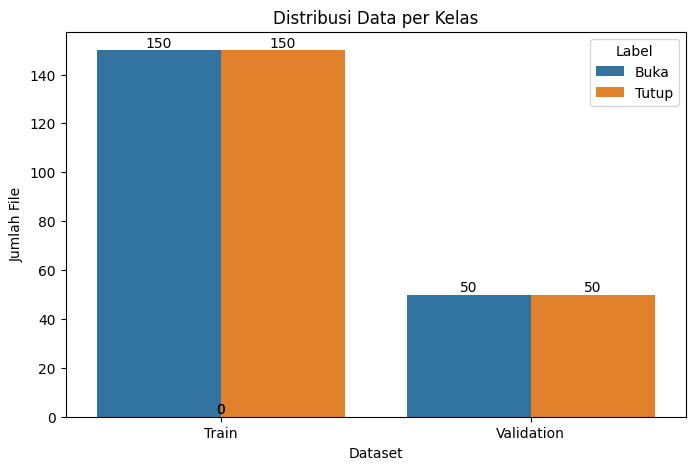

,Dataset,Buka,Tutup
0,Train,150,150
1,Validation,50,50


In [4]:
def count_files(base_path):
    counts = {}
    for label in os.listdir(base_path):
        folder = os.path.join(base_path, label)
        if os.path.isdir(folder):
            counts[label] = len(glob.glob(os.path.join(folder, "*.wav")))
    return counts

train_counts = count_files(train_path)
val_counts = count_files(val_path)

df_counts = pd.DataFrame({
    'Dataset': ['Train', 'Validation'],
    'Buka': [train_counts.get('buka', 0), val_counts.get('buka', 0)],
    'Tutup': [train_counts.get('tutup', 0), val_counts.get('tutup', 0)]
})

df_counts_melt = df_counts.melt(id_vars='Dataset', var_name='Label', value_name='Jumlah')

plt.figure(figsize=(8,5))
ax = sns.barplot(data=df_counts_melt, x='Dataset', y='Jumlah', hue='Label')
plt.title("Distribusi Data per Kelas")
plt.xlabel("Dataset")
plt.ylabel("Jumlah File")

# Tambah label jumlah di atas bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), ".0f"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.show()

df_counts


### Visualisasi Waveform Audio  

Visualisasi waveform dilakukan untuk membandingkan karakteristik sinyal antara kelas **buka** dan **tutup**. Waveform menunjukkan perubahan amplitudo terhadap waktu yang dapat mengindikasikan perbedaan pola bunyi dari kedua jenis suara.


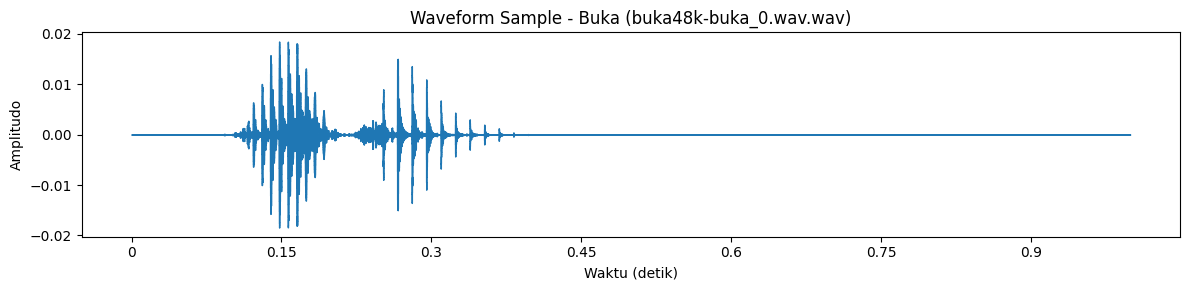

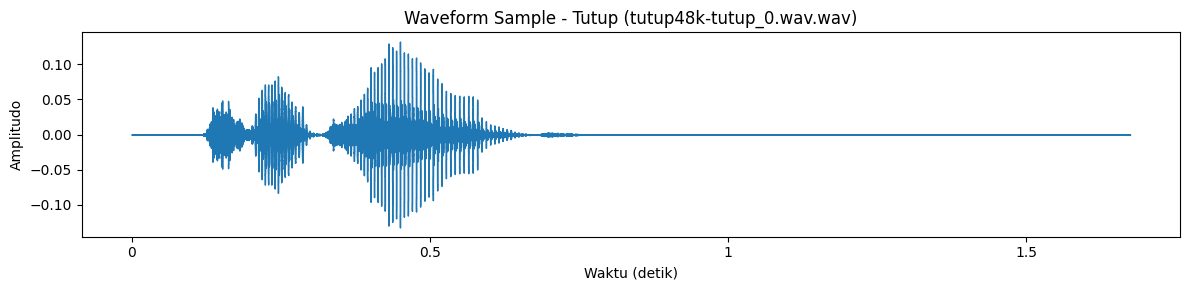

In [5]:
# Visualisasi waveform contoh audio
def plot_waveform(file_path, title):
    y, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Waktu (detik)")
    plt.ylabel("Amplitudo")
    plt.tight_layout()
    plt.show()

if buka_files:
    plot_waveform(buka_files[0], f"Waveform Sample - Buka ({os.path.basename(buka_files[0])})")

if tutup_files:
    plot_waveform(tutup_files[0], f"Waveform Sample - Tutup ({os.path.basename(tutup_files[0])})")


### Contoh audio  

Memberikan preview audio dari masing-masing kelas untuk analisis kualitatif, Validasi kualitas data dengan mendengar langsung sampel audio.

In [6]:
# Play audio buka sample
sample_buka = buka_files[0]
print("Contoh audio BUKA:", os.path.basename(sample_buka))
display(ipd.Audio(sample_buka))

# Play audio tutup sample
sample_tutup = tutup_files[0]
print("Contoh audio TUTUP:", os.path.basename(sample_tutup))
display(ipd.Audio(sample_tutup))


Contoh audio BUKA: buka48k-buka_0.wav.wav


Contoh audio TUTUP: tutup48k-tutup_0.wav.wav


### Analisis Durasi dan Sample Rate

Analisis durasi dan sample rate dilakukan untuk memastikan data audio memiliki format yang konsisten. Perbedaan durasi audio akan mempengaruhi jumlah sampel dalam sinyal sehingga ekstraksi fitur harus menggunakan metode standardisasi durasi.  

Sample rate penting karena menentukan resolusi sinyal dan rentang frekuensi yang bisa ditangkap.  

Berikut dilakukan analisis:
- Variasi sample rate antar file.
- Distribusi durasi untuk kelas **buka** dan **tutup**.

In [7]:
# Mengambil seluruh file train buka & tutup
all_files = buka_files + tutup_files

durations = []
sample_rates = []
labels_list = []

for f in all_files:
    y, sr = librosa.load(f, sr=None)
    durations.append(len(y) / sr)
    sample_rates.append(sr)
    label = "buka" if "buka" in f.lower() else "tutup"
    labels_list.append(label)

df_audio_info = pd.DataFrame({
    "File": all_files,
    "Durasi (detik)": durations,
    "Sample Rate": sample_rates,
    "Label": labels_list
})

df_audio_info.head()


,File,Durasi (detik),Sample Rate,Label
0,C:\Semester5\psd\psd\dataset48k\train\buka\buk...,0.999375,48000,buka
1,C:\Semester5\psd\psd\dataset48k\train\buka\buk...,3.794292,48000,buka
2,C:\Semester5\psd\psd\dataset48k\train\buka\buk...,3.794292,48000,buka
3,C:\Semester5\psd\psd\dataset48k\train\buka\buk...,3.034292,48000,buka
4,C:\Semester5\psd\psd\dataset48k\train\buka\buk...,3.034292,48000,buka


Visualisasi Distribusi Sample Rate.

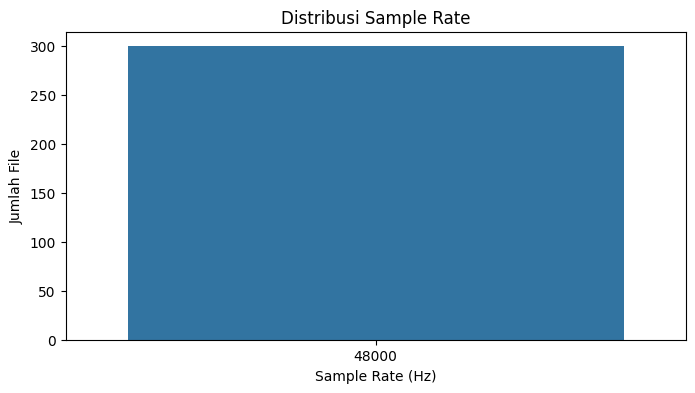

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(x=sample_rates)
plt.title("Distribusi Sample Rate")
plt.xlabel("Sample Rate (Hz)")
plt.ylabel("Jumlah File")
plt.show()


Visualisasi Durasi Audio (Histogram + Per Kelas).

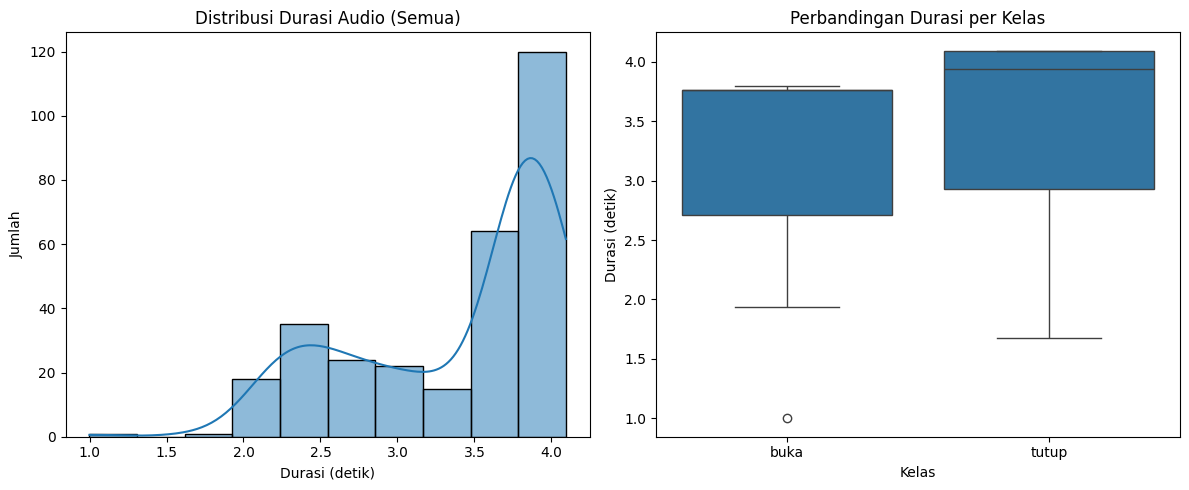

In [9]:
plt.figure(figsize=(12,5))

# Histogram umum
plt.subplot(1,2,1)
sns.histplot(durations, kde=True)
plt.title("Distribusi Durasi Audio (Semua)")
plt.xlabel("Durasi (detik)")
plt.ylabel("Jumlah")

# Boxplot per kelas
plt.subplot(1,2,2)
sns.boxplot(x=labels_list, y=durations)
plt.title("Perbandingan Durasi per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Durasi (detik)")

plt.tight_layout()
plt.show()


## Preprocessing Audio

Pada tahap ini dilakukan preprocessing untuk memastikan setiap file audio:
1. Memiliki sample rate yang seragam (22.050 Hz).
2. Memiliki durasi tetap (1 detik).
3. Telah dinormalisasi amplitudonya.

Standarisasi diperlukan agar ekstraksi fitur statistik dapat dilakukan secara konsisten 
dan model Machine Learning dapat melakukan pembelajaran dengan lebih baik.


In [10]:
TRAIN_DIR = "dataset48k/train"
VAL_DIR   = "dataset48k/val"

# Parameter preprocessing
TARGET_SR = 22050         # target sample rate
TARGET_DURATION = 1.0     # target durasi 1 detik
MAX_LEN = int(TARGET_SR * TARGET_DURATION)

def preprocess_audio(file_path, target_sr=TARGET_SR, target_len=MAX_LEN, noise_reduction=True):
    y, sr = librosa.load(file_path, sr=target_sr)

    # Padding atau trimming agar durasi 1 detik
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)), mode='constant')
    else:
        y = y[:target_len]

    # Normalisasi amplitudo (skala -1 sampai 1)
    y = y / np.max(np.abs(y) + 1e-6)
    
    # Hilangkan noise kecil
    if noise_reduction:
        y[np.abs(y) < 0.005] = 0.0

    return y, sr


### Visualisasi Perbandingan Sebelum vs Sesudah preprocessing

Sample rate asli: 48000 Hz | Durasi asli: 3.03s
Sample rate baru: 22050 Hz | Durasi baru: 1.00s


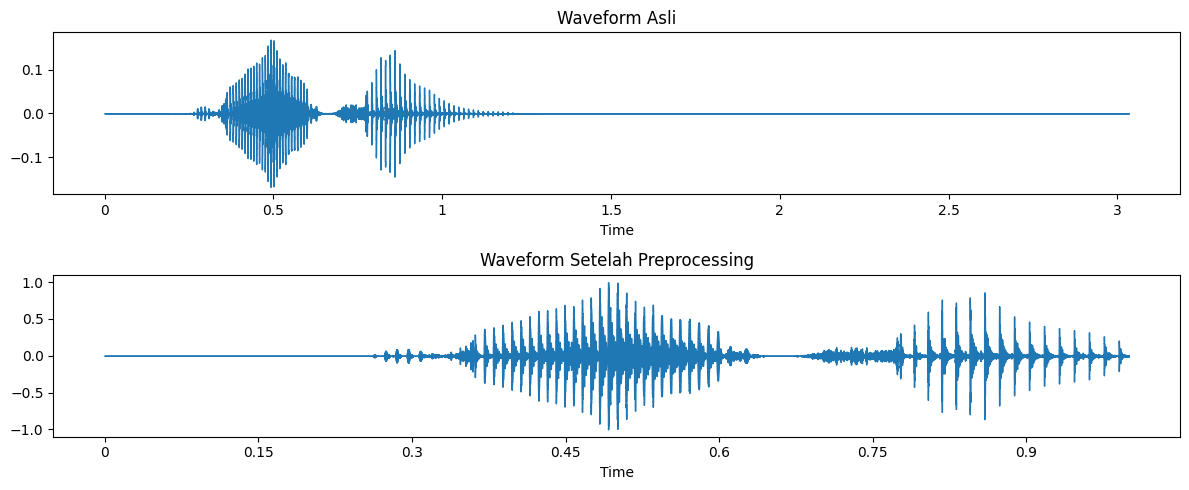

Sebelum preprocessing:


Setelah preprocessing:


In [11]:
sample_file = os.path.join(TRAIN_DIR, "buka", os.listdir(os.path.join(TRAIN_DIR, "buka"))[10])

y_raw, sr_raw = librosa.load(sample_file, sr=None)
y_proc, sr_proc = preprocess_audio(sample_file)

print(f"Sample rate asli: {sr_raw} Hz | Durasi asli: {len(y_raw)/sr_raw:.2f}s")
print(f"Sample rate baru: {sr_proc} Hz | Durasi baru: {len(y_proc)/sr_proc:.2f}s")

fig, ax = plt.subplots(2, 1, figsize=(12, 5))
librosa.display.waveshow(y_raw, sr=sr_raw, ax=ax[0])
ax[0].set_title("Waveform Asli")
librosa.display.waveshow(y_proc, sr=sr_proc, ax=ax[1])
ax[1].set_title("Waveform Setelah Preprocessing")
plt.tight_layout()
plt.show()

print("Sebelum preprocessing:")
ipd.display(ipd.Audio(y_raw, rate=sr_raw))
print("Setelah preprocessing:")
ipd.display(ipd.Audio(y_proc, rate=sr_proc))

### Buat dataset hasil preprocessing  

Langkah ini akan membaca semua file audio, preprocessing semuanya, dan menyimpannya dalam bentuk list siap ekstraksi fitur.

In [12]:

def create_preprocessed_dataset(dir_path, output_pkl):
    data = []
    labels = []
    file_names = []

    for label in ['buka', 'tutup']:
        folder = os.path.join(dir_path, label)
        if not os.path.exists(folder):
            print(f"Folder tidak ditemukan: {folder}")
            continue

        for file in os.listdir(folder):
            if file.endswith(".wav"):
                file_path = os.path.join(folder, file)
                y, sr = preprocess_audio(file_path)
                data.append(y)
                labels.append(label)
                file_names.append(file_path)

    # Simpan file .pkl
    joblib.dump(
        {"audio": np.array(data), "label": np.array(labels), "file": file_names},
        output_pkl
    )
    
    print(f"Saved: {output_pkl}")
    print(f"Total data disimpan: {len(data)}")


# Generate file Train dan Validation
create_preprocessed_dataset(TRAIN_DIR, "train_preprocessed.pkl")
create_preprocessed_dataset(VAL_DIR, "val_preprocessed.pkl")


Saved: train_preprocessed.pkl
Total data disimpan: 300
Saved: val_preprocessed.pkl
Total data disimpan: 100


Quick-Check .pkl

In [13]:
# Load Train Dataset
print("DATA TRAIN")
train_data = joblib.load("train_preprocessed.pkl")
print("Shape Audio :", train_data['audio'].shape)
print("Label Sample:", train_data['label'][:10])
print("File Sample :", train_data['file'][:3])

# Load Validation Dataset
print("\nDATA VALIDASI")
val_data = joblib.load("val_preprocessed.pkl")
print("Shape Audio :", val_data['audio'].shape)
print("Label Sample:", val_data['label'][:10])
print("File Sample :", val_data['file'][:3])


DATA TRAIN
Shape Audio : (300, 22050)
Label Sample: ['buka' 'buka' 'buka' 'buka' 'buka' 'buka' 'buka' 'buka' 'buka' 'buka']
File Sample : ['dataset48k/train\\buka\\buka48k-buka_0.wav.wav', 'dataset48k/train\\buka\\buka48k-buka_1.wav.wav', 'dataset48k/train\\buka\\buka48k-buka_10.wav.wav']

DATA VALIDASI
Shape Audio : (100, 22050)
Label Sample: ['buka' 'buka' 'buka' 'buka' 'buka' 'buka' 'buka' 'buka' 'buka' 'buka']
File Sample : ['dataset48k/val\\buka\\buka48k-buka_150.wav.wav', 'dataset48k/val\\buka\\buka48k-buka_151.wav.wav', 'dataset48k/val\\buka\\buka48k-buka_152.wav.wav']


visualisasi statistik amplitudo.

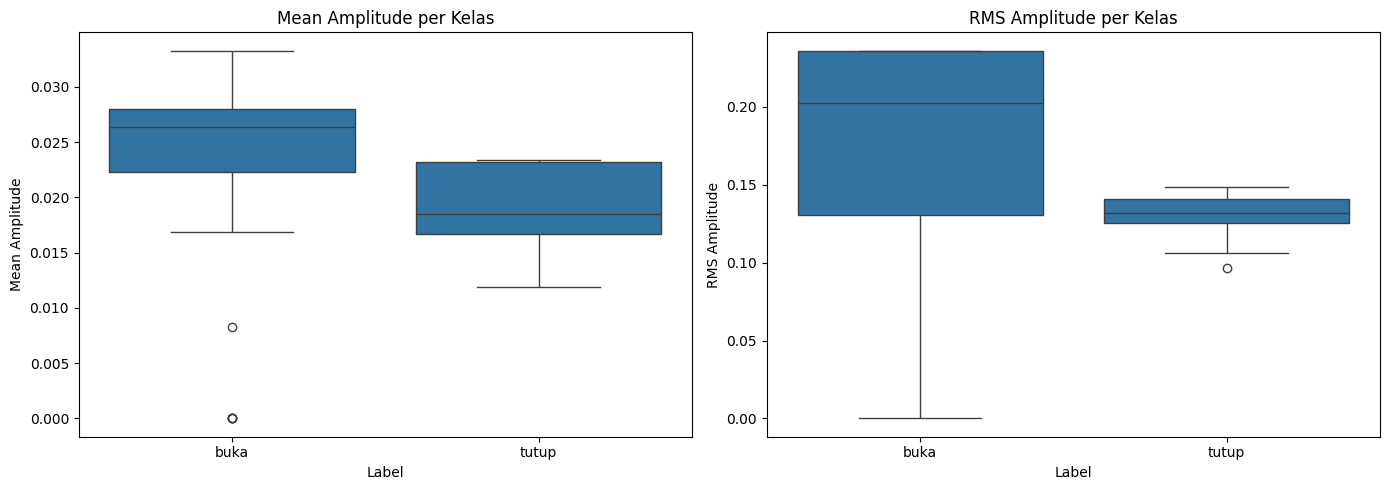

In [14]:
train_data = joblib.load("train_preprocessed.pkl")
val_data = joblib.load("val_preprocessed.pkl")

train_labels = train_data['label']
val_labels = val_data['label']

# Hitung statistik amplitude
mean_amp = [np.mean(x) for x in train_data['audio']]
rms_amp = [np.sqrt(np.mean(x**2)) for x in train_data['audio']]

df_stats = pd.DataFrame({
    "Label": train_labels,
    "Mean Amplitude": mean_amp,
    "RMS Amplitude": rms_amp
})

fig, ax = plt.subplots(1, 2, figsize=(14,5))

sns.boxplot(data=df_stats, x="Label", y="Mean Amplitude", ax=ax[0])
ax[0].set_title("Mean Amplitude per Kelas")

sns.boxplot(data=df_stats, x="Label", y="RMS Amplitude", ax=ax[1])
ax[1].set_title("RMS Amplitude per Kelas")

plt.tight_layout()
plt.show()

## Ekstraksi Fitur Statistik Time Series  

Pada tahap ini, setiap audio diproses menjadi vektor fitur yang berisi
informasi statistik domain waktu dan frekuensi.  

Fitur meliputi:
- Mean, Std, Variance, RMS.
- Zero Crossing Rate.
- Spectral Centroid, Rolloff, Bandwidth.
- Kurtosis, Skewness.

Setiap file audio direpresentasikan menjadi satu baris data dalam bentuk tabel CSV.


In [15]:
def extract_features(y, sr=22050):
    # Time domain features
    mean_val = np.mean(y)
    std_val = np.std(y)
    var_val = np.var(y)
    rms_val = np.sqrt(np.mean(y**2))
    zcr_val = np.mean(librosa.feature.zero_crossing_rate(y))

    min_val = np.min(y)
    max_val = np.max(y)
    peak_to_peak = max_val - min_val
    median_val = np.median(y)
    iqr_val = iqr(y)
    energy = np.sum(y**2)
    entropy_energy = -np.sum((y**2) * np.log(y**2 + 1e-12))

    skew_val = skew(y)
    kurt_val = kurtosis(y)

    # Frequency domain features
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    entropy_spectral = -np.sum(centroid * np.log(abs(centroid) + 1e-12))

    return [
        mean_val, std_val, var_val, rms_val, zcr_val,
        min_val, max_val, peak_to_peak, median_val, iqr_val,
        energy, entropy_energy, skew_val, kurt_val,
        centroid, rolloff, bandwidth, flatness,
        contrast, entropy_spectral
    ]

### Bangun Dataset Fitur dari train & val  

looping seluruh audio hasil preprocessing dan ambil fiturnya.

In [16]:
def create_feature_csv(input_pkl, output_csv):
    data_loaded = joblib.load(input_pkl)
    audios = data_loaded['audio']
    labels = data_loaded['label']
    filenames = data_loaded['file']

    header = [
        "mean", "std", "var", "rms", "zcr",
        "min", "max", "peak_to_peak", "median", "iqr",
        "energy", "entropy_energy", "skew", "kurt",
        "centroid", "rolloff", "bandwidth", "flatness",
        "contrast", "entropy_spectral",
        "label", "filename"
    ]

    rows = []
    
    TARGET_SR = 22050
    for i in range(len(audios)):
        feats = extract_features(audios[i], TARGET_SR)
        feats.append(labels[i])
        feats.append(filenames[i])
        rows.append(feats)

    # Simpan fitur ke CSV
    df = pd.DataFrame(rows, columns=header)
    df.to_csv(output_csv, index=False)
    print(f"Saved: {output_csv} | Total: {len(df)} data")


# Generate train & validation CSV
create_feature_csv("train_preprocessed.pkl", "train_features.csv")
create_feature_csv("val_preprocessed.pkl", "val_features.csv")

train_df = pd.read_csv("train_features.csv")
train_df.head()

Saved: train_features.csv | Total: 300 data
Saved: val_features.csv | Total: 100 data


,mean,std,var,rms,zcr,min,max,peak_to_peak,median,iqr,...,skew,kurt,centroid,rolloff,bandwidth,flatness,contrast,entropy_spectral,label,filename
0,0.008289,0.088983,0.007918,0.089368,0.018732,-0.656841,0.999946,1.656787,0.0,0.000000,...,4.885885,50.250577,605.665806,1204.880593,755.521365,0.640915,15.672460,-3880.094029,buka,dataset48k/train\buka\buka48k-buka_0.wav.wav
1,0.022353,0.129079,0.016661,0.131000,0.030351,-0.652882,0.999998,1.652880,0.0,0.016813,...,2.274273,12.117165,789.759494,1384.976474,1147.908386,0.277465,16.669738,-5269.060896,buka,dataset48k/train\buka\buka48k-buka_1.wav.wav
2,0.022355,0.129085,0.016663,0.131007,0.030262,-0.652917,0.999998,1.652915,0.0,0.016804,...,2.274226,12.116864,787.535417,1381.550737,1143.620848,0.277453,16.686843,-5252.001514,buka,dataset48k/train\buka\buka48k-buka_10.wav.wav
3,0.022768,0.128476,0.016506,0.130477,0.044178,-0.660273,0.999992,1.660265,0.0,0.017138,...,2.394795,12.654151,812.500350,1384.487083,1159.718023,0.230714,17.035061,-5443.846876,buka,dataset48k/train\buka\buka48k-buka_100.wav.wav
4,0.022702,0.128487,0.016509,0.130477,0.044334,-0.660802,0.999985,1.660787,0.0,0.022010,...,2.395947,12.666134,816.326387,1393.540816,1165.261393,0.230852,17.117811,-5473.316800,buka,dataset48k/train\buka\buka48k-buka_101.wav.wav


### Feature Selection + Normalisasi  

Tahap ini untuk:
- Optimalkan fitur terbaik.
- Hindari fitur yang tidak berkontribusi → tingkatkan akurasi.
- Buat skala fitur konsisten → agar classifier bekerja optimal.  

Load Data + Pisahkan Fitur & Label.

In [17]:
# Load dataset fitur
train_df = pd.read_csv("train_features.csv")
val_df   = pd.read_csv("val_features.csv")

# Pisahkan fitur dan label
# Pastikan kolom 'label' ada di dataset
X_train = train_df.drop(columns=["label", "filename"], errors="ignore")
y_train = train_df['label']

X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

# Encoding label (ubah dari string ke angka)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

print(f"Data Train: {train_df.shape}, Data Val: {val_df.shape}")
display(train_df.head())


Data Train: (300, 22), Data Val: (100, 22)


,mean,std,var,rms,zcr,min,max,peak_to_peak,median,iqr,...,skew,kurt,centroid,rolloff,bandwidth,flatness,contrast,entropy_spectral,label,filename
0,0.008289,0.088983,0.007918,0.089368,0.018732,-0.656841,0.999946,1.656787,0.0,0.000000,...,4.885885,50.250577,605.665806,1204.880593,755.521365,0.640915,15.672460,-3880.094029,buka,dataset48k/train\buka\buka48k-buka_0.wav.wav
1,0.022353,0.129079,0.016661,0.131000,0.030351,-0.652882,0.999998,1.652880,0.0,0.016813,...,2.274273,12.117165,789.759494,1384.976474,1147.908386,0.277465,16.669738,-5269.060896,buka,dataset48k/train\buka\buka48k-buka_1.wav.wav
2,0.022355,0.129085,0.016663,0.131007,0.030262,-0.652917,0.999998,1.652915,0.0,0.016804,...,2.274226,12.116864,787.535417,1381.550737,1143.620848,0.277453,16.686843,-5252.001514,buka,dataset48k/train\buka\buka48k-buka_10.wav.wav
3,0.022768,0.128476,0.016506,0.130477,0.044178,-0.660273,0.999992,1.660265,0.0,0.017138,...,2.394795,12.654151,812.500350,1384.487083,1159.718023,0.230714,17.035061,-5443.846876,buka,dataset48k/train\buka\buka48k-buka_100.wav.wav
4,0.022702,0.128487,0.016509,0.130477,0.044334,-0.660802,0.999985,1.660787,0.0,0.022010,...,2.395947,12.666134,816.326387,1393.540816,1165.261393,0.230852,17.117811,-5473.316800,buka,dataset48k/train\buka\buka48k-buka_101.wav.wav


Normalisasi (StandardScaler)

Scaler berhasil disimpan sebagai scaler.pkl


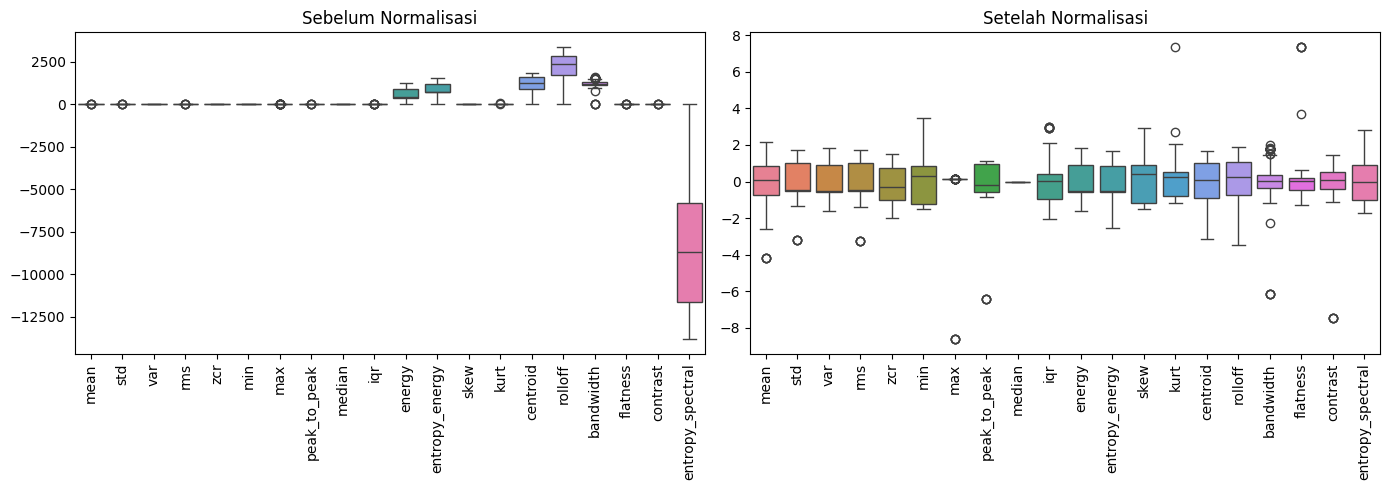

In [18]:
# Hanya ambil kolom numerik agar scaler tidak error
X_train_num = X_train.select_dtypes(include=['number'])
X_val_num = X_val.select_dtypes(include=['number'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_val_scaled = scaler.transform(X_val_num)

# Kembalikan ke DataFrame dengan nama kolom
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_num.columns)

joblib.dump(scaler, "scaler.pkl")

print("Scaler berhasil disimpan sebagai scaler.pkl")

# Visualisasi perbandingan
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title("Sebelum Normalisasi")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.boxplot(data=X_train_scaled_df)
plt.title("Setelah Normalisasi")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Feature Selection — RandomForest Feature Importance

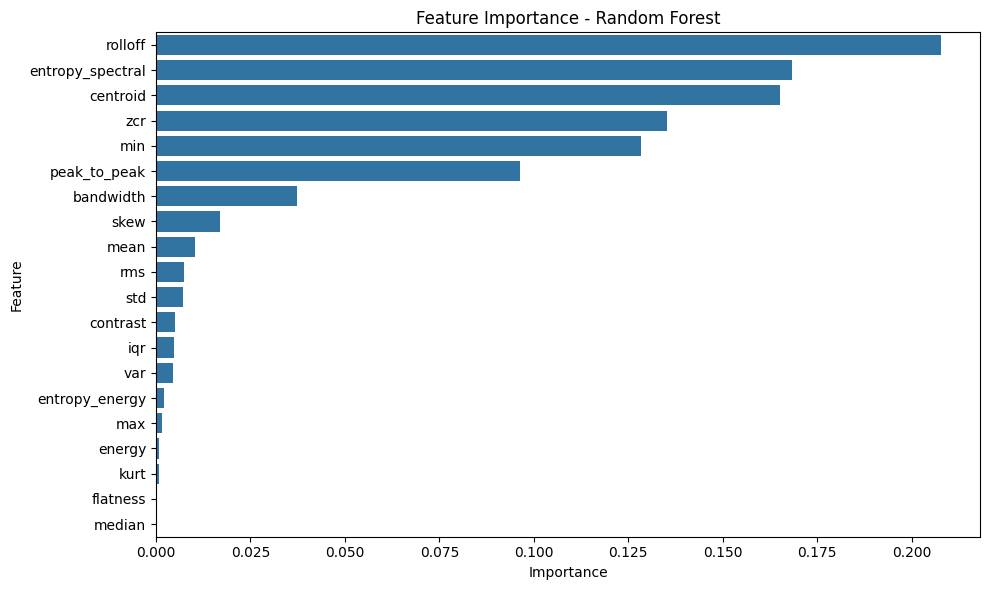

,Feature,Importance
15,rolloff,0.207717
19,entropy_spectral,0.168291
14,centroid,0.165084
4,zcr,0.135198
5,min,0.128408
7,peak_to_peak,0.096447
16,bandwidth,0.037183
12,skew,0.017031
0,mean,0.010230
3,rms,0.007358


In [19]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled_df, y_train_enc)

# Feature Importance
importances = rf.feature_importances_
feature_names = X_train_num.columns

feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df, x="Importance", y="Feature")
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

# Tampilkan 10 fitur terpenting
feat_imp_df.head(10)

## Modeling menggunakan Random Forest  


### Train Model Random Forest

In [20]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train_enc)

RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

### Evaluasi Model

In [21]:
y_pred_enc = rf.predict(X_val_scaled)

print("Accuracy:", accuracy_score(y_val_enc, y_pred_enc))
print("\nClassification Report:")
print(classification_report(y_val_enc, y_pred_enc, target_names=le.classes_))

# Save Model
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(le, "label_encoder.pkl")

print("MODEL & ENCODER BERHASIL DISIMPAN!")

Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

        buka       0.89      1.00      0.94        50
       tutup       1.00      0.88      0.94        50

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100

MODEL & ENCODER BERHASIL DISIMPAN!


### Confusion Matrix Visual

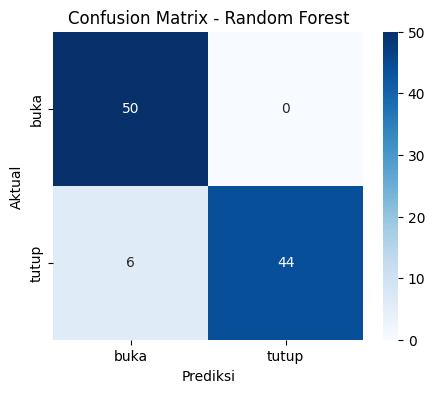

In [22]:
cm = confusion_matrix(y_val_enc, y_pred_enc)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

## Prediksi Pada Audio Buka Tutup Baru  

Pada bagian ini, sistem akan mengidentifikasi apakah suara yang diberikan
termasuk kategori **buka** atau **tutup** secara otomatis dan menampilkan confidence score.

In [23]:
import librosa
import numpy as np
import pandas as pd
import joblib
import os
from scipy.stats import skew, kurtosis, iqr
import IPython.display as ipd

# ===============================
# KONFIGURASI DASAR
# ===============================
TARGET_SR = 22050
MODEL_PATH = "random_forest_model.pkl"
ENCODER_PATH = "label_encoder.pkl"
SCALER_PATH = "scaler.pkl"  # pastikan kamu juga simpan scaler saat training

# ===============================
# EKSTRAKSI FITUR (HARUS SAMA DENGAN TRAINING)
# ===============================
def extract_features(y, sr=TARGET_SR):
    # Normalisasi amplitudo
    y = y / (np.max(np.abs(y)) + 1e-6)
    
    # Time domain features
    mean_val = np.mean(y)
    std_val = np.std(y)
    var_val = np.var(y)
    rms_val = np.sqrt(np.mean(y**2))
    zcr_val = np.mean(librosa.feature.zero_crossing_rate(y))
    min_val = np.min(y)
    max_val = np.max(y)
    peak_to_peak = max_val - min_val
    median_val = np.median(y)
    iqr_val = iqr(y)
    energy = np.sum(y**2)
    entropy_energy = -np.sum((y**2) * np.log(y**2 + 1e-12))
    skew_val = skew(y)
    kurt_val = kurtosis(y)

    # Frequency domain features
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    entropy_spectral = -np.sum(centroid * np.log(abs(centroid) + 1e-12))

    return np.array([
        mean_val, std_val, var_val, rms_val, zcr_val,
        min_val, max_val, peak_to_peak, median_val, iqr_val,
        energy, entropy_energy, skew_val, kurt_val,
        centroid, rolloff, bandwidth, flatness,
        contrast, entropy_spectral
    ])

# ===============================
# PREDIKSI AUDIO
# ===============================
def prediksi_audio(folder="dataset48k/val/buka/", indeks=0):
    # Cek keberadaan file model
    for file in [MODEL_PATH, ENCODER_PATH, SCALER_PATH]:
        if not os.path.exists(file):
            print(f"❌ File {file} tidak ditemukan!")
            return

    # Load model, label encoder, dan scaler
    model = joblib.load(MODEL_PATH)
    le = joblib.load(ENCODER_PATH)
    scaler = joblib.load(SCALER_PATH)

    # Ambil file audio dari folder
    files = sorted([f for f in os.listdir(folder) if f.endswith(".wav")])
    if not files:
        print("❌ Tidak ada file audio di folder!")
        return

    # Pilih file berdasarkan indeks
    path = os.path.join(folder, files[min(indeks, len(files)-1)])
    print(f"\n🎵 Menggunakan file: {path}")
    ipd.display(ipd.Audio(path))

    # Load dan preprocess audio
    y, sr = librosa.load(path, sr=TARGET_SR)
    y, _ = librosa.effects.trim(y, top_db=20)  # hilangkan keheningan
    if len(y) < sr:  # padding agar panjang minimal 1 detik
        y = np.pad(y, (0, sr - len(y)), mode="constant")
    else:
        y = y[:sr]

    # Ekstraksi fitur
    X_new = extract_features(y, sr).reshape(1, -1)

    # Scaling fitur agar sama seperti training
    X_scaled = scaler.transform(X_new)

    # Prediksi
    pred_enc = model.predict(X_scaled)[0]
    proba = model.predict_proba(X_scaled)[0]

    pred_label = le.inverse_transform([pred_enc])[0]

    print("\n=== HASIL PREDIKSI ===")
    print(f"🎯 Label Prediksi : {pred_label.upper()}")
    print(f"📊 Confidence     : {max(proba)*100:.2f}%")
    print(f"🔹 Probabilitas   : Buka={proba[0]*100:.1f}%, Tutup={proba[1]*100:.1f}%")
    print("==========================================")

# ===============================
# CONTOH PEMANGGILAN
# ===============================
prediksi_audio(folder="dataset48k/val/buka/", indeks=2)



🎵 Menggunakan file: dataset48k/val/buka/buka48k-buka_152.wav.wav



=== HASIL PREDIKSI ===
🎯 Label Prediksi : BUKA
📊 Confidence     : 100.00%
🔹 Probabilitas   : Buka=100.0%, Tutup=0.0%


## IMPLEMENTASI MODEL (Deployment)

### Load dan simpan model pada folder deploy

In [25]:
import os
import joblib
import numpy as np

# Load Model
MODEL_FILE = "random_forest_model.pkl"
SCALER_FILE = "scaler.pkl"
ENCODER_FILE = "label_encoder.pkl"

print("Semua .pkl berhasil diload.")

# Simpan ulang ke folder lain
SAVE_DIR = "../../psd_deploy_bukatutup"
os.makedirs(SAVE_DIR, exist_ok=True)

def copy_pkl(source_path, target_dir):
    if not os.path.exists(source_path):
        print(f"File tidak ditemukan: {source_path}")
        return

    obj = joblib.load(source_path)
    target_path = os.path.join(target_dir, os.path.basename(source_path))
    joblib.dump(obj, target_path)
    print(f"{os.path.basename(source_path)} berhasil disalin ke: {target_path}")

# === Eksekusi untuk semua file ===
copy_pkl(MODEL_FILE, SAVE_DIR)
copy_pkl(SCALER_FILE, SAVE_DIR)
copy_pkl(ENCODER_FILE, SAVE_DIR)

print("\nSemua file berhasil disalin ke folder deploy!")

Semua .pkl berhasil diload.
random_forest_model.pkl berhasil disalin ke: ../../psd_deploy_bukatutup\random_forest_model.pkl
scaler.pkl berhasil disalin ke: ../../psd_deploy_bukatutup\scaler.pkl
label_encoder.pkl berhasil disalin ke: ../../psd_deploy_bukatutup\label_encoder.pkl

Semua file berhasil disalin ke folder deploy!


### Membuat file `app.py` dengan code:  


```python
import streamlit as st
import os
import librosa
import numpy as np
import pandas as pd
from scipy import stats
import joblib
import tempfile
import plotly.graph_objects as go
import plotly.express as px

# ===================== PAGE CONFIG =====================
st.set_page_config(
    page_title="Audio Classifier - Buka vs Tutup",
    page_icon="",
    layout="wide"
)

# ===================== CUSTOM CSS =====================
st.markdown("""
<style>
body { background-color: #0e1117; color: #f8f9fa; }
h1, h2, h3, h4 { color: #a5d7ff; text-align: center; }
.stButton > button {
    background: linear-gradient(90deg, #004e92, #000428);
    color: white; border-radius: 8px;
    padding: 0.6rem 1.2rem; font-size: 1.05rem;
    transition: all 0.3s ease;
}
.stButton > button:hover {
    background: linear-gradient(90deg, #6a11cb, #2575fc);
    transform: scale(1.05);
}
.result-card {
    background-color: #1a1d23; border-radius: 12px;
    padding: 1rem; text-align: center;
    margin-top: 1rem; box-shadow: 0px 0px 10px rgba(0,0,0,0.4);
}
.result-buka { border: 2px solid #3df55e; }
.result-tutup { border: 2px solid #ff4d4d; }
.footer {
    text-align: center; color: #8c8c8c;
    margin-top: 3rem; font-size: 0.9rem;
}
</style>
""", unsafe_allow_html=True)

# ===================== LOAD MODEL / SCALER / ENCODER =====================
@st.cache_resource
def load_resources():
    try:
        model = joblib.load("random_forest_model.pkl")
        scaler = joblib.load("scaler.pkl")
        le = joblib.load("label_encoder.pkl")
        return model, scaler, le, True
    except Exception as e:
        st.error(f"Gagal memuat model atau file pendukung: {e}")
        return None, None, None, False

# ===================== FEATURE EXTRACTION =====================
def extract_features(y, sr=22050):
    y = y / (np.max(np.abs(y)) + 1e-6)
    feats = [
        np.mean(y), np.std(y), np.var(y),
        np.sqrt(np.mean(y**2)),
        np.mean(librosa.feature.zero_crossing_rate(y)),
        np.min(y), np.max(y), np.ptp(y),
        np.median(y), stats.iqr(y),
        np.sum(y**2),
        -np.sum((y**2) * np.log(y**2 + 1e-12)),
        stats.skew(y), stats.kurtosis(y),
        np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)),
        np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        np.mean(librosa.feature.spectral_flatness(y=y)),
        np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
        -np.sum(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) * np.log(np.abs(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))) + 1e-12))
    ]
    return pd.DataFrame([feats])

# ===================== AUDIO PREPROCESSING =====================
def preprocess_audio(y, sr, target_sr=22050, duration=1.0):
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    max_len = int(sr * duration)
    y = np.pad(y, (0, max_len - len(y)), mode="constant") if len(y) < max_len else y[:max_len]
    y = y / (np.max(np.abs(y)) + 1e-6)
    return y, sr

# ===================== PREDICT FUNCTION =====================
def predict_audio(file, model, scaler, le):
    y, sr = librosa.load(file, sr=None)
    y, sr = preprocess_audio(y, sr)
    X_new = extract_features(y, sr)

    # Normalisasi fitur
    X_scaled = scaler.transform(X_new)

    pred_enc = model.predict(X_scaled)[0]
    proba = model.predict_proba(X_scaled)[0]

    pred_label = le.inverse_transform([pred_enc])[0]
    return pred_label, proba, y, sr

# ===================== PLOTS =====================
def plot_waveform(y, sr):
    time = np.linspace(0, len(y)/sr, len(y))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=time, y=y, mode="lines", line=dict(color="#2ca8ff")))
    fig.update_layout(
        title="Waveform",
        xaxis_title="Time (s)",
        yaxis_title="Amplitude",
        height=250,
        margin=dict(l=0, r=0, t=40, b=0),
        paper_bgcolor="#0e1117", plot_bgcolor="#0e1117",
        font=dict(color="#f8f9fa")
    )
    return fig

def plot_spectrogram(y, sr):
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    fig = px.imshow(S_dB, color_continuous_scale="magma", aspect="auto")
    fig.update_layout(
        title="Mel Spectrogram",
        xaxis_title="Frame", yaxis_title="Mel bands",
        height=300, margin=dict(l=0, r=0, t=40, b=0),
        paper_bgcolor="#0e1117", plot_bgcolor="#0e1117",
        font=dict(color="#f8f9fa")
    )
    return fig

# ===================== MAIN APP =====================
def main():
    st.markdown("<h1>Audio Classifier: Suara Buka vs Tutup</h1>", unsafe_allow_html=True)
    st.write("Upload audio berdurasi **1 detik (WAV)** untuk mendeteksi apakah suara tersebut adalah **‘Buka’** atau **‘Tutup’.**")

    model, scaler, le, loaded = load_resources()
    if not loaded:
        st.stop()

    uploaded_file = st.file_uploader("Upload file audio (.wav)", type=["wav"])

    if uploaded_file is not None:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
            tmp.write(uploaded_file.read())
            temp_path = tmp.name

        st.audio(uploaded_file, format="audio/wav")

        if st.button("Jalankan Prediksi"):
            with st.spinner("Menganalisis audio..."):
                pred_label, proba, y, sr = predict_audio(temp_path, model, scaler, le)

            col1, col2 = st.columns([1, 1])

            with col1:
                if pred_label.lower() == "buka":
                    st.markdown(f'<div class="result-card result-buka"><h2>PREDIKSI: BUKA</h2><p>Confidence: {max(proba)*100:.1f}%</p></div>', unsafe_allow_html=True)
                else:
                    st.markdown(f'<div class="result-card result-tutup"><h2>PREDIKSI: TUTUP</h2><p>Confidence: {max(proba)*100:.1f}%</p></div>', unsafe_allow_html=True)

                prob_df = pd.DataFrame({"Kelas": le.classes_, "Probabilitas (%)": proba * 100})
                fig_bar = px.bar(prob_df, x="Kelas", y="Probabilitas (%)",
                                 color="Kelas", color_discrete_sequence=["#3df55e", "#ff4d4d"])
                fig_bar.update_layout(paper_bgcolor="#0e1117", plot_bgcolor="#0e1117",
                                      font=dict(color="#f8f9fa"), height=300)
                st.plotly_chart(fig_bar, use_container_width=True)

            with col2:
                st.plotly_chart(plot_waveform(y, sr), use_container_width=True)
                st.plotly_chart(plot_spectrogram(y, sr), use_container_width=True)

        os.unlink(temp_path)

# ===================== RUN =====================
if __name__ == "__main__":
    main()

```

Link GitHub: https://github.com/AqbilBarakaa/psd_deploy_bukatutup

### Mempersiapkan lingkungan aplikasi

In [27]:
%pip install streamlit librosa numpy pandas scikit-learn scipy plotly joblib soundfile


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Menjalankan Aplikasi  

```streamlit run app.py```

### Hasil Deploy:  

https://psddeploybukatutup.streamlit.app/